In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.tree import plot_tree

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('training_dataset.csv')
df1=pd.read_csv('testing_dataset.csv')

In [4]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1.0,2.0,0.0,892.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,0,1,3,0,3,0,2,0,0,...,1.0,2.0,1.0,9540.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,0,0,1,0,0,0,0,0,0,...,1.0,2.0,3.0,589.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,0,2,5,0,0,0,0,0,0,...,1.0,2.0,0.0,292.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2,0,0,0,0,0,0,0,0,0,...,1.0,2.0,1.0,3597.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
df.describe(include='all')

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,...,58770.000000,58770.000000,58770.000000,58770.000000,58769.000000,58769.000000,58769.000000,58769.000000,58769.000000,58769.000000
mean,2.192816,0.332494,0.113985,1.283728,0.009188,0.207807,0.021967,0.141515,0.002688,0.001157,...,1.132891,2.771873,1.740599,6206.654399,0.505828,0.342851,0.001021,0.001838,0.005207,0.345675
std,1.226189,1.122767,0.644810,1.895239,0.116893,0.962466,0.255504,0.925634,0.077125,0.075378,...,0.893484,1.319455,1.706185,12087.141967,0.499970,0.785938,0.056851,0.063074,0.071971,0.475592
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2100.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10799.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df=df.fillna(0)
df1=df1.fillna(0)

In [ ]:
# List of useful columns
useful_columns = [
    'qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length', 'qty_dot_directory',
    'qty_hyphen_directory', 'qty_slash_directory', 'directory_length', 'qty_dot_file',
    'qty_questionmark_file', 'file_length','email_in_url','qty_tld_url','qty_hyphen_url','phishing'

]
# Drop other columns from the DataFrame
df = df[useful_columns]
df1=df1[useful_columns]

In [ ]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of length_url is : 17.3634117972455
The skewness of qty_dot_url is : 5.423429966548654
The skewness of qty_hyphen_url is : 7.830055099634531
The skewness of qty_slash_url is : 2.115097532562723
The skewness of qty_tld_url is : 6.709775830871398
The skewness of domain_length is : 3.358949423089712
The skewness of qty_dot_directory is : 2.2810552805352122
The skewness of email_in_url is : 7.126843588609052
The skewness of phishing is : 0.6490555084361906


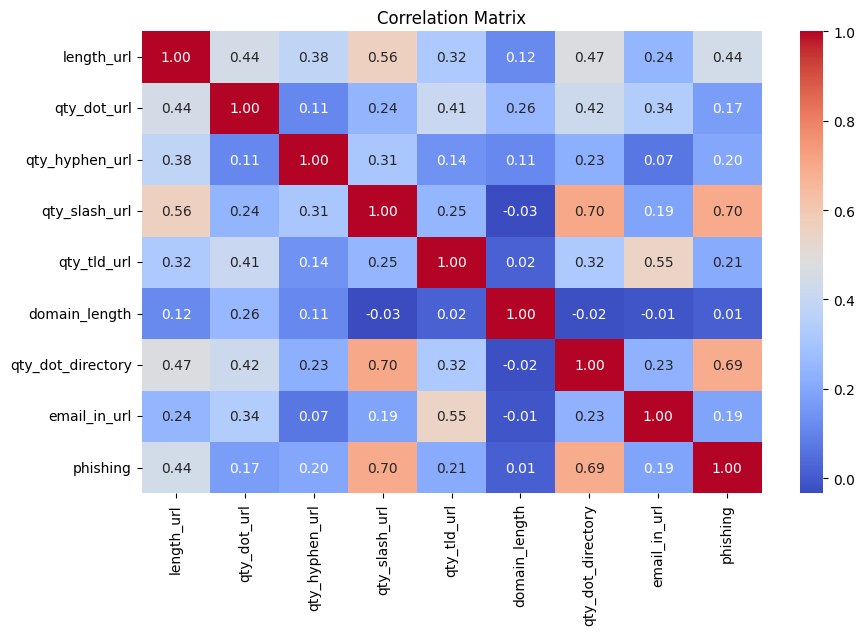

In [ ]:
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
def impute_outliers(data, column):
    Q1 = data[column].quantile(0.10)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = data[column].mean()
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])
    return data

columns_to_check = ['email_in_url','qty_tld_url','qty_hyphen_url']
data=df.copy()
for column in columns_to_check:
    data = impute_outliers(data, column)

df=data

In [ ]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of length_url is : 17.3634117972455
The skewness of qty_dot_url is : 5.423429966548654
The skewness of qty_hyphen_url is : 2.519491964641667
The skewness of qty_slash_url is : 2.115097532562723
The skewness of qty_tld_url is : 4.292907831649265
The skewness of domain_length is : 3.358949423089712
The skewness of qty_dot_directory is : 2.2810552805352122
The skewness of email_in_url is : 7.1268435886090575
The skewness of phishing is : 0.6490555084361906


In [ ]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of length_url is : 17.3634117972455
The skewness of qty_dot_url is : 5.423429966548654
The skewness of qty_hyphen_url is : 2.519491964641667
The skewness of qty_slash_url is : 2.115097532562723
The skewness of qty_tld_url is : 4.292907831649265
The skewness of domain_length is : 3.358949423089712
The skewness of qty_dot_directory is : 2.2810552805352122
The skewness of email_in_url is : 7.1268435886090575
The skewness of phishing is : 0.6490555084361906


In [ ]:
df.head()

,length_url,qty_dot_url,qty_hyphen_url,qty_slash_url,qty_tld_url,domain_length,qty_dot_directory,email_in_url,phishing
0,25,3,0.0,1,1.000000,17,1,0.0,1.0
1,223,5,0.0,3,1.047234,16,3,0.0,1.0
2,15,2,0.0,1,1.000000,14,0,0.0,0.0
3,81,4,0.0,5,1.000000,19,2,0.0,1.0
4,19,2,0.0,0,1.000000,19,-1,0.0,0.0


In [ ]:
df1.columns

Index(['length_url', 'qty_dot_url', 'qty_hyphen_url', 'qty_slash_url',
       'qty_tld_url', 'domain_length', 'qty_dot_directory', 'email_in_url',
       'phishing'],
      dtype='object')

In [ ]:
x_train=df.drop(['phishing'],axis=1).values
y_train=df['phishing'].values

In [ ]:
x_test=df1.drop(['phishing'],axis=1).values
y_test=df1['phishing'].values

In [ ]:
RF=RandomForestClassifier(n_estimators=100,random_state=42)
RF_Model=RF.fit(x_train,y_train)

In [ ]:
y_test.shape

(14999,)

In [ ]:
y_pred=RF_Model.predict(x_test)

In [ ]:
y_pred.shape

(14999,)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9794
           1       0.91      0.86      0.88      5205

    accuracy                           0.92     14999
   macro avg       0.92      0.91      0.91     14999
weighted avg       0.92      0.92      0.92     14999



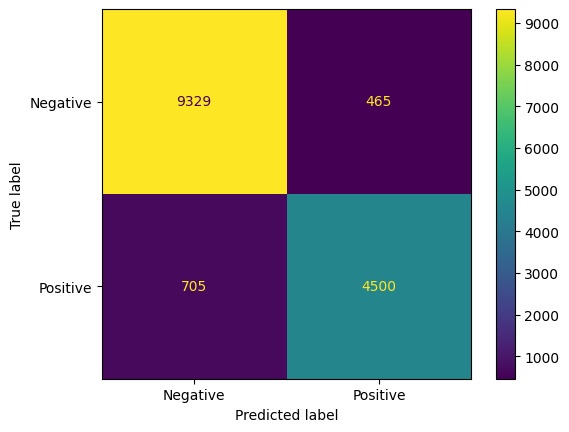

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

In [ ]:
with open("phishing_detection_model.pkl", "wb") as file:
    pickle.dump(RF_Model, file)
print("Model saved successfully!")

Model saved successfully!
